In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import math
import random
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
%matplotlib inline
sns.set_style('white')

This notebook is meant to illustrate the differences between a logistic regression model vs a ridge regression model vs a LASSO regression model

In [2]:
vadata = pd.read_excel('../datasets/offensesknowntopolice/table_8_offenses_known_to_law_enforcement_virginia_by_city_2013.xls')

vadata = vadata.drop([len(vadata.index)-2, len(vadata.index)-1])
vadata = vadata.drop(range(0,4))

colnames = ['city','population','violentcrime','murder','revisedrape','legacyrape','robbery','aggravatedassault','propertycrime','burglary','larceny','autotheft','arson']
vadata.columns = colnames
vadata = vadata.fillna(value='0')

In [3]:
#replace all these freaking strings with ints by removing the commas
def remove_commas(x):
    return str(x).replace(',','')

vadata = vadata.applymap(remove_commas)

In [4]:
#change the data type of all the numerical data to a float
def makefloat(x):
    if str(x).isdigit():
        return float(x)
    else:
        return(x)

vadata = vadata.applymap(makefloat)

In [5]:
murderbools = []
robberybools = []
violentbools = []
for val in vadata['murder']:
    murderbools.append(val > 0)
for val in vadata['robbery']:
    robberybools.append(val > 0)
for val in vadata['violentcrime']:
    violentbools.append(val > 0)
    
vadata['murderbool'] = murderbools 
vadata['robberybool'] = robberybools
vadata['violentbool'] = violentbools

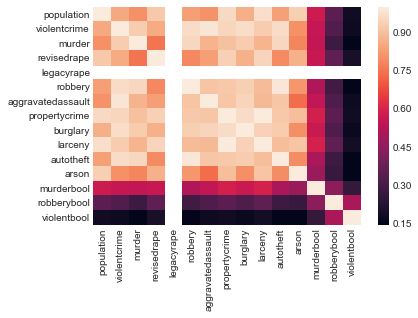

In [6]:
sns.heatmap(vadata.corr())

In [7]:
vadata = vadata.drop('legacyrape', 1)

In [8]:
#there were some pretty big correlations in the heatmap, better drop some of them
corrmat = vadata.corr()
upper = corrmat.where(np.triu(np.ones(corrmat.shape), k=1).astype(np.bool))

to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [9]:
vadata = vadata.drop(to_drop, 1)

In [10]:
vadata = vadata.drop('city', 1)

In [11]:
#better scale the data first before splitting it up into train and test sets
bools = ['murderbool', 'robberybool', 'violentbool']
colnames = vadata.drop(bools, 1).columns
scaled_data = pd.DataFrame(preprocessing.scale(vadata.drop(bools, 1)), columns=colnames)
for label in bools:
    list_of_bools = vadata.loc[:, label].values
    scaled_data[label] = list_of_bools

In [12]:
#now that we dropped highly correlated features, split the data into training and test sets
#the split will be 50/50
#then we will train 3 models on the training set, with the target outcome variable of violentbool
#violentbool is true if violent crime has occurred in the city
X = scaled_data.drop('violentbool', 1)

Y = scaled_data.violentbool

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.5, random_state=0)

In [13]:
#then train some models on the training data set
#first, logistic regression
logregl1 = linear_model.LogisticRegression(penalty='l1')
logregl2 = linear_model.LogisticRegression()#penalty is 'l2' by default

logregl1.fit(x_train, y_train)
logregl2.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [14]:
#second, ridge regression
ridgereg = linear_model.Ridge(alpha=1)

ridgereg.fit(x_train, y_train)

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [15]:
#third, lasso regression
lassoreg = linear_model.Lasso(alpha=1)

lassoreg.fit(x_train, y_train)

Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [24]:
#then test the alpha values for the ridge and lasso sets
alphas = [.1, .5, 1, 5, 10, 50, 100, 500, 1000]
param_grid = {'alpha' : alphas}

ridge_optimization = GridSearchCV(ridgereg, param_grid, cv=5, scoring='r2')
lasso_optimization = GridSearchCV(lassoreg, param_grid, cv=5, scoring='r2')

ridge_optimization.fit(x_train, y_train)
lasso_optimization.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [25]:
print('Best Ridge parameter: ' + str(ridge_optimization.best_params_))
print('Best Lasso parameter: ' + str(lasso_optimization.best_params_))

Best Ridge parameter: {'alpha': 1}
Best Lasso parameter: {'alpha': 0.1}


In [34]:
ridgereg.get_params().keys()

dict_keys(['alpha', 'copy_X', 'fit_intercept', 'max_iter', 'normalize', 'random_state', 'solver', 'tol'])

In [36]:
ridgereg.set_params(**ridge_optimization.best_params_)
lassoreg.set_params(**lasso_optimization.best_params_)

ridgereg.fit(x_train, y_train)
lassoreg.fit(x_train, y_train)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [40]:
#cross validate both logistic regression models
print('Mean R^2 Logistic Regression with L1 Penalties')
print(np.mean(cross_val_score(logregl1, x_train, y_train, cv=10)))
print('Mean R^2 Logistic Regression with L2 Penalties')
print(np.mean(cross_val_score(logregl2, x_train, y_train, cv=10)))

Mean R^2 Logistic Regression with L1 Penalties
0.8277777777777777
Mean R^2 Logistic Regression with L2 Penalties
0.8277777777777777


Looks like it doesn't matter which parameter the logistic model takes, we'll just use the L2 since it's the default

In [41]:
print('Testing logistic regression model on test set:')
print(logregl2.score(x_test, y_test))
print('Testing ridge regression model on test set:')
print(ridgereg.score(x_test, y_test))
print('Testing lasso regression model on test set:')
print(lassoreg.score(x_test, y_test))

Testing logistic regression model on test set:
0.7333333333333333
Testing ridge regression model on test set:
0.240342707060625
Testing lasso regression model on test set:
-0.04233763862142248


So, the logistic regression model worked best. The R^2 values for the ridge and lasso models make me think I used the wrong model. I think because the target outcome was binary, not a continuous value.